In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from ens_util import *
from math import isnan
from sklearn.calibration import calibration_curve
plt.rcParams['figure.figsize'] = [12,12]

In [2]:
data_files = glob('data_crop*.nc')
res_files = glob('2014*Z_crs_gauss.nc')
coordx = [258,260]
coordy = [63,65]
thresh = 0.2
data = build_datadf(data_files,coordx,coordy)
(fr15,fr30,fr45,fr60) = build_weighted_fractions_prob(res_files,data.index,data.columns,coordx,coordy,thresh)
fr = [fr15,fr30,fr45,fr60]

weighted fractions


In [3]:
index_dates = data.index.date
index_dates_unique = np.unique(index_dates)
index_times = data.index
bs15 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs30 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs45 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs60 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs = [bs15,bs30,bs45,bs60]

In [4]:
#Better way to do the brier score calculations

data_bin = data.mask(data<thresh,other=1)
data_bin = data_bin.mask(data_bin!=1.0,other=0)

for c in data.columns:
    for d in index_dates_unique:
        times = index_times[np.where(index_dates==d)]
        sat = data_bin.loc[times,[c]]
        for f in range(4):
            frac = fr[f].loc[times,[c]]
            bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
            valid = np.where(np.invert(np.isnan(bs_vals)))
            bs[f].at[d,c] = np.sum(bs_vals[valid])/len(bs_vals[valid])

In [5]:
#Brier Score decomposition
c=0
f=0
d=index_dates_unique[0]
times = index_times[np.where(index_dates==d)]
sat = data_bin.loc[times,[c]]
frac = fr[f].loc[times,[c]]

bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
sat_vals = sat.values[:,0].astype(np.float)
frac_vals = frac.values[:,0].astype(np.float)

valid = np.where(np.invert(np.isnan(bs_vals)))
bs_valid = bs_vals[valid]
sat_valid = sat_vals[valid]
frac_valid = frac_vals[valid]
print(bs_valid,sat_valid,frac_valid)

[1.60000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.25314633e-05 1.07480330e-02 8.46513614e-02 5.97397650e-03
 1.04565039e-01 2.49281880e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.6        1.         1.         1.         1.         1.
 1.         1.         0.99646002 0.89632728 0.70905093 0.9227085
 0.67663482 0.99984211 1.         1.         1.         1.        ]


In [6]:
# Follows Wilks Ch. 8
unique,counts = np.unique(frac_valid,return_counts=True) #counts are N_i values
n = np.sum(counts) # n

obar_i = np.zeros(len(unique))
for j in range(len(unique)):
    y = unique[j]
    wh = np.where(frac_valid==y)
    obar_i[j] = np.sum(sat_valid[wh])/counts[j]

obar = np.sum(sat_valid)/n

sig = obar*(1-obar)
rel = np.sum(np.multiply(counts,(unique-obar_i)**2))/n
res = np.sum(np.multiply(counts,(obar_i-obar)**2))/n

print(rel,res,sig,rel-res+sig)

0.020330609235287286 0.0 0.0 0.020330609235287286


In [7]:
# would have to create new columns for each coordinate location
dec15 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs'])
dec30 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs'])
dec45 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs'])
dec60 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs'])
dec = [dec15,dec30,dec45,dec60]

c=0
for d in index_dates_unique:
    times = index_times[np.where(index_dates==d)]
    sat = data_bin.loc[times,[c]]
    for f in range(4):
        frac = fr[f].loc[times,[c]]
        bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
        sat_vals = sat.values[:,0].astype(np.float)
        frac_vals = frac.values[:,0].astype(np.float)
        valid = np.where(np.invert(np.isnan(bs_vals)))
        bs_valid = bs_vals[valid]
        sat_valid = sat_vals[valid]
        frac_valid = frac_vals[valid]
        
        unique,counts = np.unique(frac_valid,return_counts=True)
        n = np.sum(counts)
        obar_i = np.zeros(len(unique))
        for j in range(len(unique)):
            y = unique[j]
            wh = np.where(frac_valid==y)
            obar_i[j] = np.sum(sat_valid[wh])/counts[j]
        obar = np.sum(sat_valid)/n

        sig = obar*(1-obar)
        rel = np.sum(np.multiply(counts,(unique-obar_i)**2))/n
        res = np.sum(np.multiply(counts,(obar_i-obar)**2))/n
        dec[f].at[d,'rel'] = rel
        dec[f].at[d,'res'] = res
        dec[f].at[d,'sig'] = sig
        dec[f].at[d,'bs'] = rel-res+sig
print(dec60)

                    rel          res        sig           bs
2014-04-02    0.0804296            0          0    0.0804296
2014-04-05     0.163764         0.16       0.16     0.163764
2014-04-09    0.0126579            0          0    0.0126579
2014-04-10   0.00269948            0          0   0.00269948
2014-04-11     0.234351     0.222222   0.222222     0.234351
2014-04-12     0.445987    0.0812698   0.195556     0.560273
2014-04-15    0.0833271     0.115556   0.115556    0.0833271
2014-04-18    0.0494497            0          0    0.0494497
2014-04-19      0.20143         0.24       0.24      0.20143
2014-04-20   0.00161252            0          0   0.00161252
2014-04-21  0.000683395            0          0  0.000683395
2014-04-22   0.00177875            0          0   0.00177875
2014-04-25   0.00798772            0          0   0.00798772
2014-04-26     0.233065         0.16       0.16     0.233065
2014-05-05   0.00266667            0          0   0.00266667
2014-05-06    0.0897446 

In [8]:
avg_ci = [0.07326633937050787,
 0.20778712302975885,
 0.11192718638706237,
 0.06896607381887883,
 0.14332269534242617,
 0.25472343970477335,
 0.04777688933358877,
 0.8596485152665307,
 0.19564074560864855,
 0.06170793115020668,
 0.021583633585999476,
 0.03259704694624734,
 0.03989605709146575,
 0.5405269801579695,
 0.013546266323385918,
 0.06124534490048805,
 0.05463109817092926,
 0.03606780100144922,
 0.0638700738320475,
 0.03620355300317931,
 0.04244338007354623,
 0.009881199632866159,
 0.033942529421483604,
 0.009342719017178461,
 0.05944429052055939,
 0.10105394353402507,
 0.6654091999523657,
 0.0021613105745977136,
 0.013400553711767014,
 0.017006162006099224,
 0.09350540001254598,
 0.10001397910002892,
 0.006636670686108557,
 0.09580385996389294,
 0.08552496468202024,
 0.16219456934530282,
 0.10637936657699525,
 0.017298070474985355,
 0.0015729371576519585]

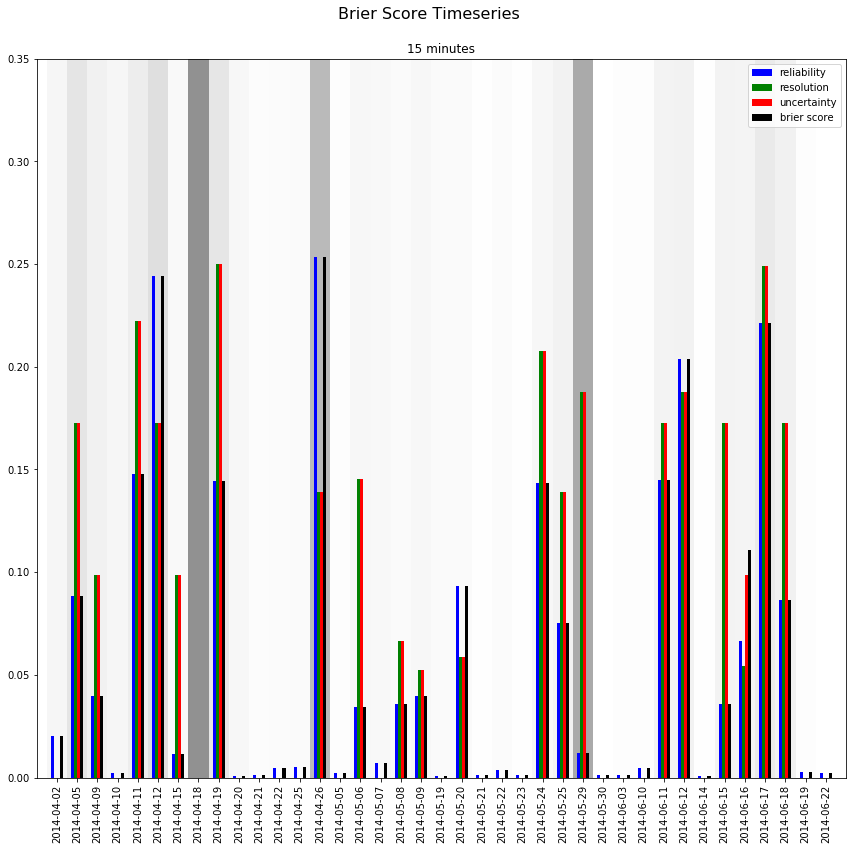

In [9]:
plt.rcParams['figure.figsize'] = [12,12]
ymin= 0
ymax = 0.35
rows = 1; cols = 1;

x = list(dec15.index)
xpos = np.array(range(len(x)))+1
width = 0.15
dx = width/2

fig,ax = plt.subplots(rows,cols)
ax.set_ylim([ymin,ymax])
ax.set_xlim([0,len(xpos)+1])
ax.set_xticks(xpos)
ax.set_xticklabels(x,rotation='vertical')

ax.bar(xpos-3*dx,dec15.values[:,0],width=width,color='b',label='reliability')
ax.bar(xpos-dx,dec15.values[:,1],width=width,color='g',label='resolution')
ax.bar(xpos+dx,dec15.values[:,2],width=width,color='r',label='uncertainty')
ax.bar(xpos+3*dx,dec15.values[:,3],width=width,color='k',label='brier score')

for i in range(1,len(x)+1):
    alpha = 0.5*avg_ci[i-1]
    ax.fill_between(np.arange(i-0.5,i+0.501,0.1),ymin,ymax,facecolor='k',alpha=alpha)

ax.set_title("15 minutes")

#fig.autofmt_xdate()
fig.tight_layout()
fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.legend()
plt.show()

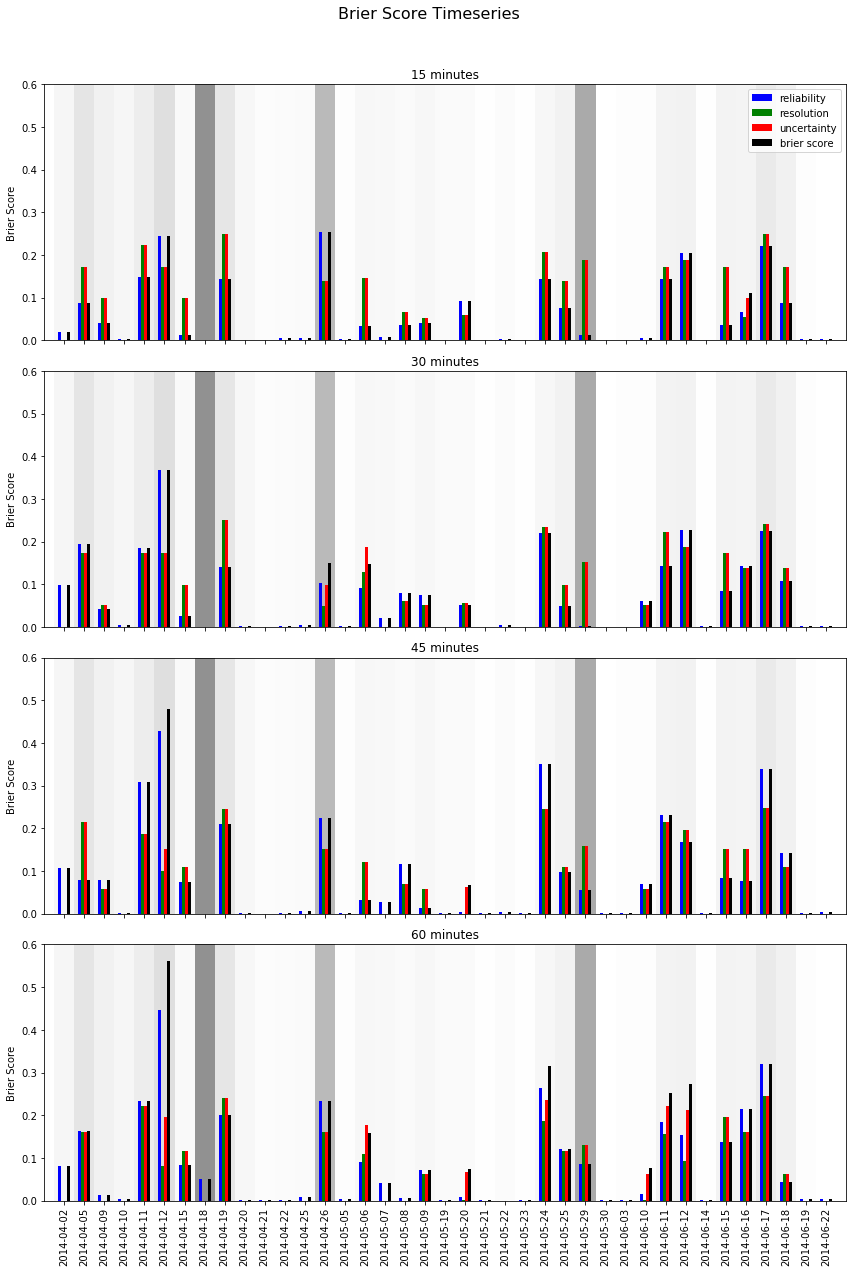

In [13]:
plt.rcParams['figure.figsize'] = [12,18]
ymin= 0
ymax = 0.6
rows = 4; cols = 1;
fig,ax = plt.subplots(rows,cols,sharex=True)
for r in range(rows):
    for c in range(cols):
        ax[r].set_ylim([ymin,ymax])
        ax[r].set_xlim([0,len(xpos)+1])
        ax[r].set_xticks(xpos)
        ax[r].set_xticklabels(x,rotation='vertical')
        ax[r].set_ylabel('Brier Score')
        
ax[0].bar(xpos-3*dx,dec15.values[:,0],width=width,color='b',label='reliability')
ax[0].bar(xpos-dx,dec15.values[:,1],width=width,color='g',label='resolution')
ax[0].bar(xpos+dx,dec15.values[:,2],width=width,color='r',label='uncertainty')
ax[0].bar(xpos+3*dx,dec15.values[:,3],width=width,color='k',label='brier score')

ax[1].bar(xpos-3*dx,dec30.values[:,0],width=width,color='b',label='reliability')
ax[1].bar(xpos-dx,dec30.values[:,1],width=width,color='g',label='resolution')
ax[1].bar(xpos+dx,dec30.values[:,2],width=width,color='r',label='uncertainty')
ax[1].bar(xpos+3*dx,dec30.values[:,3],width=width,color='k',label='brier score')

ax[2].bar(xpos-3*dx,dec45.values[:,0],width=width,color='b',label='reliability')
ax[2].bar(xpos-dx,dec45.values[:,1],width=width,color='g',label='resolution')
ax[2].bar(xpos+dx,dec45.values[:,2],width=width,color='r',label='uncertainty')
ax[2].bar(xpos+3*dx,dec45.values[:,3],width=width,color='k',label='brier score')

ax[3].bar(xpos-3*dx,dec60.values[:,0],width=width,color='b',label='reliability')
ax[3].bar(xpos-dx,dec60.values[:,1],width=width,color='g',label='resolution')
ax[3].bar(xpos+dx,dec60.values[:,2],width=width,color='r',label='uncertainty')
ax[3].bar(xpos+3*dx,dec60.values[:,3],width=width,color='k',label='brier score')

for a in range(4):
    for i in range(1,len(x)+1):
        alpha = 0.5*avg_ci[i-1]
        ax[a].fill_between(np.arange(i-0.5,i+0.501,0.1),ymin,ymax,facecolor='k',alpha=alpha)

ax[0].set_title("15 minutes")
ax[1].set_title("30 minutes")
ax[2].set_title("45 minutes")
ax[3].set_title("60 minutes")

ax[0].legend()

#fig.autofmt_xdate()
fig.tight_layout()
fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()

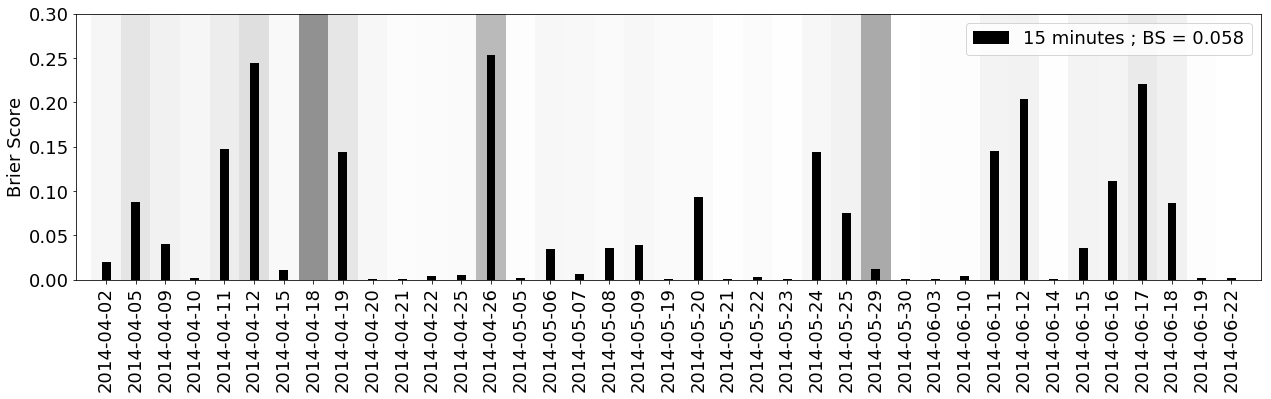

In [37]:
plt.rcParams['figure.figsize'] = [18,6]
plt.rcParams.update({'font.size': 18})
ymin= 0
ymax = 0.3
rows = 1; cols = 1;
fig,ax = plt.subplots(rows,cols,sharex=True)
ax.set_ylim([ymin,ymax])
ax.set_xlim([0,len(xpos)+1])
ax.set_xticks(xpos)
ax.set_xticklabels(x,rotation='vertical')
ax.set_ylabel('Brier Score')

width = 0.3
ax.bar(xpos,dec15.values[:,3],width=width,color='k',label='15 minutes ; BS = 0.058')
#ax.bar(xpos-dx,dec30.values[:,3],width=width,color='g',label='30 minutes')
#ax.bar(xpos+dx,dec45.values[:,3],width=width,color='r',label='45 minutes')
#ax.bar(xpos+3*dx,dec60.values[:,3],width=width,color='k',label='60 minutes')

for i in range(1,len(x)+1):
    alpha = 0.5*avg_ci[i-1]
    ax.fill_between(np.arange(i-0.5,i+0.501,0.1),ymin,ymax,facecolor='k',alpha=alpha)

ax.legend()

#fig.autofmt_xdate()
fig.tight_layout()
#fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()

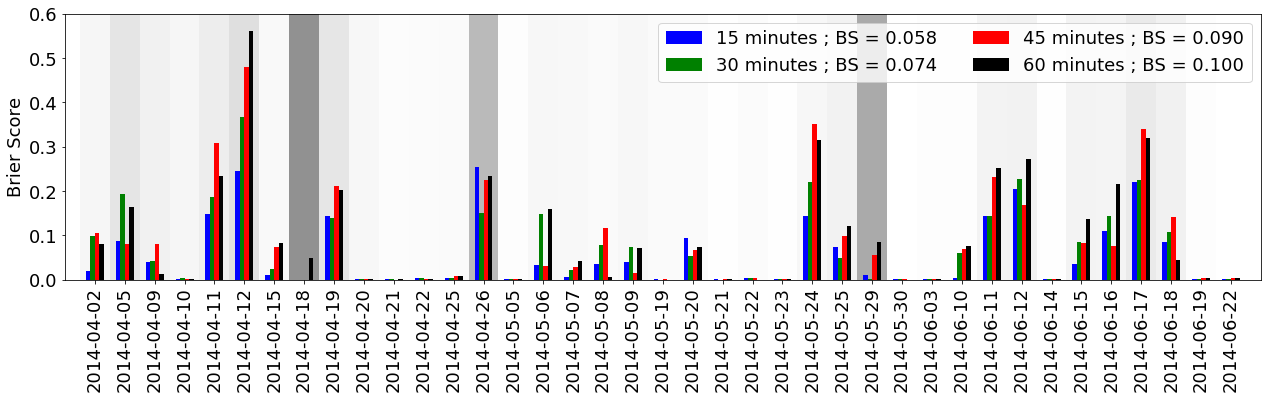

In [42]:
plt.rcParams['figure.figsize'] = [18,6]
plt.rcParams.update({'font.size': 18})
ymin= 0
ymax = 0.6
width = 0.15
rows = 1; cols = 1;
fig,ax = plt.subplots(rows,cols,sharex=True)
ax.set_ylim([ymin,ymax])
ax.set_xlim([0,len(xpos)+1])
ax.set_xticks(xpos)
ax.set_xticklabels(x,rotation='vertical')
ax.set_ylabel('Brier Score')
        
ax.bar(xpos-3*dx,dec15.values[:,3],width=width,color='b',label='15 minutes ; BS = 0.058')
ax.bar(xpos-dx,dec30.values[:,3],width=width,color='g',label='30 minutes ; BS = 0.074')
ax.bar(xpos+dx,dec45.values[:,3],width=width,color='r',label='45 minutes ; BS = 0.090')
ax.bar(xpos+3*dx,dec60.values[:,3],width=width,color='k',label='60 minutes ; BS = 0.100')

for i in range(1,len(x)+1):
    alpha = 0.5*avg_ci[i-1]
    ax.fill_between(np.arange(i-0.5,i+0.501,0.1),ymin,ymax,facecolor='k',alpha=alpha)

ax.legend(loc='upper right',fontsize=18,ncol=2)

#fig.autofmt_xdate()
fig.tight_layout()
#fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()

In [29]:
dec15.index[0]

datetime.date(2014, 4, 2)

4/12, 6/18, 5/24 case studies

reference BS can be anything I want

compute overall brier score; one long timeseries, not average of individual brier scores.
change lines to bar charts, spread out length wise
look at adjustments to model statistics

do enhanced reliability diagram - read text for reminder.

"climatological" benchmark? fraction of cloudy/not over the entire timeseries at a single point.
Or: do it over the entire grid.

In [11]:
# Overall brier score
# choosing coordinate c=0
c=0

index_dates = data.index.date
index_dates_unique = np.unique(index_dates)
index_times = data.index

data_bin = data.mask(data<thresh,other=1)
data_bin = data_bin.mask(data_bin!=1.0,other=0)

sat = data_bin.loc[:,[c]]
for f in range(4):
    frac = fr[f].loc[:,[c]]
    bs_df = ((frac-sat)**2)
    times = bs_df.index.values
    bs_vals = bs_df.values[:,0].astype(np.float)
    valid = np.where(np.invert(np.isnan(bs_vals)))
    bs_valid = bs_vals[valid]
    valid_times = times[valid]
    sat_vals = sat.loc[valid_times,[c]].values[:,0]
    obar = np.sum(sat_vals)/len(sat_vals)
    
    brier = np.sum(bs_valid)/len(bs_valid)
    print((f+1)*15,'minutes :',brier)
    #print('BS = ',brier)
    print('obar = ',obar)

15 minutes : 0.05792033135091143
obar =  0.8184523809523809
30 minutes : 0.07432306875463628
obar =  0.8154761904761905
45 minutes : 0.08975956519272074
obar =  0.8113522537562604
60 minutes : 0.10005317519722358
obar =  0.8122743682310469
